In [1]:
import numpy as np
# import matplotlib; matplotlib.use("SVG")

# Getting started with `josiepy`
## A Python framework to simulate Partial Differential Equations focused on usability
### (without sacrifying performances)

<i class="fa fa-user"></i> Ruben Di Battista <br /> 
<i class="fa fa-twitter"></i> <a href="https://twitter.com/rdbisme">@rdbisme</a>

## Background
----------------------
### M. Massot Research Team
####  Mathematical modeling
- Mathematical modeling of two-phase injection in rocket engines
- Mathematical modeling of plasma flows for heliophysics and hall thrusters

#### Numerical Calculus for High Performance Computing (HPC)
- Development of numerical schemes and algorithms adapted to HPC



## `canoP`
### A C++ wrapper on `p4est`, a quad/octo-trees for parallel AMR computation, to simulate PDEs w/ AMR

- C++ is notoriously hard to master
- `p4est` is an advanced library w/ features not immediately needed when exploring numerical schemes

## Motivations
--------------------

An easy to use playground to easily implement numerical schemes on 1D, 2D (and maybe 3D in the future) structured (and maybe unstructured and non-conformal meshes... dreaming is still free 😇) meshes, in Python

## Design Choices
--------------------------




- Use Python instead of a Domain Specific Language (DSL), like the one OpenFOAM uses, or another scripting language, like `lua` in `canoP` to describe your case configuration. "You code your case configuration"

- Modern Python (Python >= 3.7) features allows static checking (through the usage of type hinting) of the code that predates some advantages of the compiled languages

- The `numpy` library and its API allows to write algorithms once while being able to run them on different architectures and different programming paradigms

   - CPU Shared memory ([numpy](https://numpy.org) + OpenMP-enabled BLAS library)
   - CPU distributed memory ([Dask](https://dask.org))
   - Nvidia GPUs with CUDA ([cupy](https://cupy.chainer.org))
   - (Soon) AMD GPUs with HIP ([cupy](https://cupy.chainer.org))
   - ... FPGA? Anyone? It's a cool project too... 
   
   Everything mostly at the same computational speed as C and C++, or faster (GPU for example)


## Numpy for `josiepy` 101
### Vectorized operations

What you would generally do in a C++-like compiled code is: 

```
for( cell : mesh.cells() ) {
    apply_compute_kernel(cell)
}

```

What we generally will do in `numpy` is operating on an array containing **all** the cells values at the same time.

Let's imagine we have the velocity vector stored in an array of size $N_\text{cells} \times \text{dim}$, where $\text{dim}$ is the dimensionality of the problem (e.g. 2D)

In [2]:
cell_values = np.random.random((30, 2))
U = cell_values[:, 0]
V = cell_values[:, 1]

Let's imagine now to have to compute a normal product between all the velocity values in each cell, and a singular 
normal vector

In [3]:
normal = np.array([1, 0])

What we could do is repeating the `normal` array $N_\text{cells}$ times and multipliying it by `cell_values`...

... but there's a better way!
The operation we want to do is

$$
    \left\{\mathbf{U}\right\} \cdot \mathbf{n} = U_{ij}n_j
$$

In [4]:
normal_velocities = np.einsum("ij,j->i", cell_values, normal)
print(normal_velocities.shape)

np.array_equal(U, normal_velocities)

(30,)


True

`numpy.einsum` is an implementation of the Einstein's tensor summation on steroids 💪. You specify the input vectors dimensions and the output dimension you want to achieve, and it figures it out automatically.

Basically:
$$
U_{ij} n_j \rightarrow u_i
$$
```
np.einsum("ij,j->i", cell_values, normal)
```
* Repeated indices on the inputs are summed as a result if they're not present in the result (after the `->`): `cell_values[i][0] * normal[0] + cell_values[i][1] * normal[1]` 

`np.einsum` avoids memory copies and if we provide the `optimize=True` keyword argument

In [5]:
A = np.random.random((1000, 1000))
B = np.random.random((1000, 1000))

%timeit np.einsum("ij,ij->", A, B)

1.08 ms ± 20.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
A = np.random.random((1000, 1000))
B = np.random.random((1000, 1000))

%timeit np.einsum("ij,ij->", A, B, optimize=True)

684 µs ± 158 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


it is gonna exploit parallelization of operations like `np.dot` and `np.tensordot` that are parallelized natively with OpenMP if the BLAS library which `numpy` is compiled on allows it 

(hint: the classical `pip install numpy` pre-compiled wheel, does not)

### Vectorized conditionals

Sometimes, for example to initialize the domain at the beginning of a simulation, or for an upwind scheme, you need to apply some conditionals of the type:

```
for (cell : mesh.cells()) {
    x, y = cell.centroid()
    
    if(x > 0.5) 
        right_state(cell)
    else
        left_state(cell)
}
```

What you would do in vectorized form, is:

In [7]:
values = np.zeros(30)
x = np.linspace(0, 1, np.size(values))
print(values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


In [8]:
values[np.where(x > 0.5)] = 1

print(values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


## Basics of `josiepy`

### Problem statement

\begin{equation}
    \partial_t \mathbf{q} + 
    \nabla \cdot \left(\underline{\underline{\mathbf{F}}}(\mathbf{q}) 
        + \underline{\underline{\underline{\underline{D(\mathbf{q})}}}} \cdot \nabla \mathbf{q} \right) +
    \underline{\underline{\underline{\mathbf{B}(\mathbf{q})}}} \cdot \nabla\mathbf{q} = 
    \mathbf{s}(\mathbf{q})
\end{equation}


\begin{equation}
    \partial_t q_p + 
    \partial_{x_r} \left(F_{pr}(q_p) + D_{pqrs}(q_p)\partial_{x_s}q_q\right) + 
    B_{pqr}\partial_{x_r}q_q = 
    s_p(q_p)
\end{equation}


### The `State` object

\begin{equation}
    \partial_t \mathbf{q} + 
    \nabla \cdot \left(\underline{\underline{\mathbf{F}}}(\mathbf{q}) 
        + \underline{\underline{\underline{\underline{D(\mathbf{q})}}}} \cdot \nabla \mathbf{q} \right) +
    \underline{\underline{\underline{\mathbf{B}(\mathbf{q})}}} \cdot \nabla\mathbf{q} = 
    \mathbf{s}(\mathbf{q})
\end{equation}


Represents the $\mathbf{q}$

In [9]:
from josie.state import State
from josie.fluid.fields import FluidFields

In [10]:
class EulerFields(FluidFields):
    rho = 0
    rhoU = 1
    rhoV = 2
    rhoE = 3
    U = 4
    V = 5
    rhoe = 6
    p = 7
    c = 8

In [11]:
class EulerState(State):
    fields = EulerFields
    
rnd_state = np.random.random(len(EulerFields)).view(EulerState)
print(rnd_state)

[0.21800124 0.44334009 0.31521554 0.33580545 0.28092686 0.77100948
 0.0988216  0.71725491 0.21517077]


In [12]:
U1 = rnd_state[EulerFields.U]
U2 = rnd_state[4]
U3 = rnd_state[-5]
U4 = rnd_state[rnd_state.fields.U]

assert np.array_equal(U1, U2) and np.array_equal(U2, U3) and np.array_equal(U3, U4)


`State` can be multidimensional! (e.g. a 2D 100x100 mesh, each cell containing an Euler state)

In [13]:
rnd_state = np.random.random((100, 100, len(EulerFields)))

In [14]:
U = rnd_state[..., EulerFields.U]
print(U.shape)

(100, 100)


The `Ellipsis` object (`...`) allows to index on the last axis, whatever dimension the array is

In [15]:
rnd_state = np.random.random((100, 100, 100, len(EulerFields)))

In [16]:
U = rnd_state[..., EulerFields.U]
print(U.shape)

(100, 100, 100)


Let's compute the normal velocity again...

In [17]:
UV = rnd_state[..., EulerFields.U : EulerFields.V + 1]

print(UV.shape)


(100, 100, 100, 2)


In [18]:
U_norm = np.einsum("...ij,j->...i", UV, normal)
print(U_norm.shape)

assert np.array_equal(U_norm, U)

(100, 100, 100)


### The `Mesh` object

A `mesh` object is used to create an manage a mesh. A `mesh` is built from `BoundaryCurves`:

In [19]:
from josie.boundary import Line, CircleArc

left = Line([0, 0], [0, 1])
bottom = CircleArc([0, 0], [1, 0], [0.5, 0.5])
right = Line([1, 0], [1, 1])
top = Line([0, 1], [1, 1])



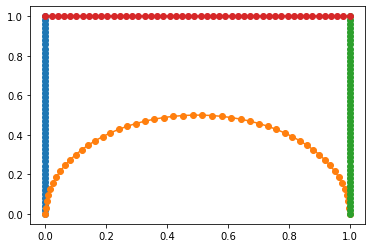

In [20]:
for curve in [left, bottom, right, top]:
    curve.plot()

You can (and need to) attach `BoundaryConditions` to each `BoundaryCurve` of a domain

In [21]:
from josie.bc import Dirichlet, Neumann

Q_zero = np.zeros(len(EulerState.fields)).view(EulerState)
dQ_zero = Q_zero

left.bc = Dirichlet(Q_zero)
top.bc = Neumann(dQ_zero)
bottom.bc = Dirichlet(Q_zero)
right.bc = Dirichlet(Q_zero)

> /home/rdb/git/x/josiepy/josie/bc.py(244)__new__()
    243         __import__("ipdb").set_trace()
--> 244         if isinstance(value, State):
    245             # An entire state was provided as value of the Dirichlet BC, so

ipdb> type(value)
<class '__main__.EulerState'>
ipdb> isinstance(value, State)
True
ipdb> n
> /home/rdb/git/x/josiepy/josie/bc.py(248)__new__()
    247             # field with the right value
--> 248             bcs = []
    249 

ipdb> n
> /home/rdb/git/x/josiepy/josie/bc.py(250)__new__()
    249 
--> 250             for field in value.fields:
    251                 bcs.append(cls.__new__(cls, value[field]))

ipdb> n
> /home/rdb/git/x/josiepy/josie/bc.py(251)__new__()
    250             for field in value.fields:
--> 251                 bcs.append(cls.__new__(cls, value[field]))
    252 

ipdb> n
> /home/rdb/git/x/josiepy/josie/bc.py(244)__new__()
    243         __import__("ipdb").set_trace()
--> 244         if isinstance(value, State):
    245            

ipdb> n
> /home/rdb/git/x/josiepy/josie/bc.py(262)__new__()
    261 
--> 262         return obj
    263 

ipdb> c
> /home/rdb/git/x/josiepy/josie/bc.py(244)__new__()
    243         __import__("ipdb").set_trace()
--> 244         if isinstance(value, State):
    245             # An entire state was provided as value of the Dirichlet BC, so

ipdb> c
> /home/rdb/git/x/josiepy/josie/bc.py(244)__new__()
    243         __import__("ipdb").set_trace()
--> 244         if isinstance(value, State):
    245             # An entire state was provided as value of the Dirichlet BC, so

ipdb> c
> /home/rdb/git/x/josiepy/josie/bc.py(244)__new__()
    243         __import__("ipdb").set_trace()
--> 244         if isinstance(value, State):
    245             # An entire state was provided as value of the Dirichlet BC, so

ipdb> c
> /home/rdb/git/x/josiepy/josie/bc.py(244)__new__()
    243         __import__("ipdb").set_trace()
--> 244         if isinstance(value, State):
    245             # An entire

ipdb> c
> /home/rdb/git/x/josiepy/josie/bc.py(244)__new__()
    243         __import__("ipdb").set_trace()
--> 244         if isinstance(value, State):
    245             # An entire state was provided as value of the Dirichlet BC, so

ipdb> c
> /home/rdb/git/x/josiepy/josie/bc.py(244)__new__()
    243         __import__("ipdb").set_trace()
--> 244         if isinstance(value, State):
    245             # An entire state was provided as value of the Dirichlet BC, so

ipdb> c
> /home/rdb/git/x/josiepy/josie/bc.py(244)__new__()
    243         __import__("ipdb").set_trace()
--> 244         if isinstance(value, State):
    245             # An entire state was provided as value of the Dirichlet BC, so

ipdb> c
> /home/rdb/git/x/josiepy/josie/bc.py(244)__new__()
    243         __import__("ipdb").set_trace()
--> 244         if isinstance(value, State):
    245             # An entire state was provided as value of the Dirichlet BC, so

ipdb> c
> /home/rdb/git/x/josiepy/josie/bc.py(244)__

ipdb> c
> /home/rdb/git/x/josiepy/josie/bc.py(244)__new__()
    243         __import__("ipdb").set_trace()
--> 244         if isinstance(value, State):
    245             # An entire state was provided as value of the Dirichlet BC, so

ipdb> c
> /home/rdb/git/x/josiepy/josie/bc.py(244)__new__()
    243         __import__("ipdb").set_trace()
--> 244         if isinstance(value, State):
    245             # An entire state was provided as value of the Dirichlet BC, so

ipdb> c
> /home/rdb/git/x/josiepy/josie/bc.py(244)__new__()
    243         __import__("ipdb").set_trace()
--> 244         if isinstance(value, State):
    245             # An entire state was provided as value of the Dirichlet BC, so

ipdb> c
> /home/rdb/git/x/josiepy/josie/bc.py(244)__new__()
    243         __import__("ipdb").set_trace()
--> 244         if isinstance(value, State):
    245             # An entire state was provided as value of the Dirichlet BC, so

ipdb> c
> /home/rdb/git/x/josiepy/josie/bc.py(244)__

You can also provide mixed Boundary conditions per each field

In [ ]:
from josie.bc import BoundaryCondition

Q_bc = EulerState(rho=Dirichlet(1), rhoU=Neumann(0), rhoV=Dirichlet(1), 
                  rhoE=Dirichlet(1), rhoe=Dirichlet(3), U=Neumann(0), 
                  V=Neumann(0), p=Dirichlet(1), c=Dirichlet(10), e=Dirichlet(1))

left.bc = BoundaryCondition(Q_bc)

> /home/rdb/git/x/josiepy/josie/bc.py(244)__new__()
    243         __import__("ipdb").set_trace()
--> 244         if isinstance(value, State):
    245             # An entire state was provided as value of the Dirichlet BC, so

ipdb> p value
1


Then you can effectively generate the mesh object

In [ ]:
from josie.mesh import Mesh
from josie.mesh.cell import SimpleCell

mesh = Mesh(left, bottom, right, top, SimpleCell)
points = mesh.interpolate(20, 20)  # Gen. internal points
mesh.generate() # Generate connectivity

In [ ]:
mesh.plot()

PS: You can create 1D meshes, creating a rectangular mesh with just 1 cell in the vertical direction

## The `Problem` object.




\begin{equation}
    \partial_t \mathbf{q} + 
    \nabla \cdot \left(\underline{\underline{\mathbf{F}}}(\mathbf{q}) 
        + \underline{\underline{\underline{\underline{D(\mathbf{q})}}}} \cdot \nabla \mathbf{q} \right) +
    \underline{\underline{\underline{\mathbf{B}(\mathbf{q})}}} \cdot \nabla\mathbf{q} = 
    \mathbf{s}(\mathbf{q})
\end{equation}


`Problem` is the "continuous" representation of our problem. It implements the $\mathbf{F}, \mathbf{D}, \mathbf{B}, \mathbf{s}$ operators

In [ ]:
from josie.problem import Problem

Problem??

In [ ]:
from josie.euler.problem import EulerProblem

EulerProblem??

## The `Scheme` object

It represents the discrete representation of our problem, after being discretized with Finite-Volume-Method

\begin{split}
    V_i\partial_t \mathbf{q}_i &+
    \sum_{f \in \text{faces}} \left| \mathbf{F} \cdot \hat{\mathbf{n}} \right|_f S_f + 
    \sum_{f \in \text{faces}} \left| \left(\mathbf{D}(\mathbf{q})\cdot\nabla\mathbf{q} \right) \cdot \hat{\mathbf{n}} \right|_f S_f + \\
    &+ \left<\mathbf{B}(\mathbf{q})\right>_i \cdot \sum_{f \in \text{faces}} \left| \mathbf{q}\hat{\mathbf{n}} \right|_f S_f
    - \left< \mathbf{s}(\mathbf{q})\right>_i V_i = \mathbf{0}
\end{split}

Schemes are organized in spatial and time schemes. 

### Spatial Schemes
Spatial schemes implement the different discretizations for each operators _w.r.t._ **a single cell and its neighbour, whatever that neighbour is (no knowledge of left/right, top/bottom, etc...)**

cell_scheme

and are organized in specific classes: 

In [ ]:
from josie.scheme.nonconservative import NonConservativeScheme
from josie.scheme.convective import ConvectiveScheme
from josie.scheme.source import SourceScheme
# from josie.scheme.diffusion import DiffusionScheme <to be implemented>


#### `ConvectiveScheme`

cell_scheme



It implements, in its `ConvectiveScheme.F` method, the discretization:

\begin{equation}
    \mathbf{F}_\frac{1}{2}(\mathbf{q})= \left| \mathbf{F} \cdot \hat{\mathbf{n}} \right|_f S_f
\end{equation}

on **one face**

In [ ]:
ConvectiveScheme.F??

#### Example `Rusanov` for Euler system

cell_scheme



It implements, in its `Rusanov.F` method, the discretization:

\begin{equation}
    \mathbf{F}_\frac{1}{2}(\mathbf{q})= 
        \frac{1}{2}\left[
            \left(\mathbf{F}(\mathbf{q}_i) + \mathbf{F}(\mathbf{q}_{i+1})\right) \cdot \hat{\mathbf{n}} - 
            \left|\text{max}(\lambda_p)\right|\left( \mathbf{q}_{i+1} - \mathbf{q}_i\right)
        \right]
\end{equation}

on **one face**

In [ ]:
from josie.euler.schemes import Rusanov

Rusanov.F??

#### `NonConservativeScheme`

cell_scheme



A discretization of the type: 

\begin{equation}
    \left<\mathbf{B}(\mathbf{q})\right>_i \cdot \sum_{f \in \text{faces}} \left| \mathbf{q}\hat{\mathbf{n}} \right|_f S_f
\end{equation}

is assumed, and the `NonConservativeScheme.G` implements the term:

\begin{equation}
    \mathbf{G}_{\frac{1}{2}}(\mathbf{q}) = \left| \mathbf{q}\hat{\mathbf{n}} \right|_f S_f
\end{equation}

#### Example `Upwind` for Baer-Nunziato non-conservative term

cell_scheme



It implements, in its `Upwind.G` method, the discretization:

\begin{equation}
    \mathbf{\alpha}_\frac{1}{2}(\mathbf{u}_i) \hat{\mathbf{n}} = 
    \left[
        \left(\mathbf{u}_{i_f} \cdot \hat{\mathbf{n}} > 0\right) \alpha_i + 
        \left(\mathbf{u}_{i_f} \cdot \hat{\mathbf{n}} < 0\right) \alpha_{i+1}
    \right] \hat{\mathbf{n}}
\end{equation}

on **one face**

In [ ]:
from josie.bn.schemes import Upwind

Upwind.G??

### Time schemes
Time schemes simply implement the time update for the discretized equation:

\begin{split}
    V_i\partial_t \mathbf{q}_i &+
    \sum_{f \in \text{faces}} \left| \mathbf{F} \cdot \hat{\mathbf{n}} \right|_f S_f + 
    \sum_{f \in \text{faces}} \left| \left(\mathbf{D}(\mathbf{q})\cdot\nabla\mathbf{q} \right) \cdot \hat{\mathbf{n}} \right|_f S_f + \\
    &+ \left<\mathbf{B}(\mathbf{q})\right>_i \cdot \sum_{f \in \text{faces}} \left| \mathbf{q}\hat{\mathbf{n}} \right|_f S_f
    - \left< \mathbf{s}(\mathbf{q})\right>_i V_i = \mathbf{0}
\end{split}

In compact form:
\begin{equation}
    \partial_t \mathbf{q}_i = - \frac{1}{V_i}\mathbf{f}\left(\mathbf{q}_i, t\right)
\end{equation}

where $\mathbf{f}$ contains all the discretized space operators. Integrating in time:

\begin{equation}
    q_i^{k+1} = q_i^k - \frac{1}{V_i}\int_t^{t + \Delta t} \mathbf{f}\left(\mathbf{q}_i, \tilde{t}\right)\; \text{d}t
\end{equation}

`TimeScheme`

It implements the term $\frac{1}{V_i}\int_t^{t+\Delta t} \mathbf{f}\left(\mathbf{q}_i, \tilde{t}\right)\; \text{d}t$

In [ ]:
from josie.scheme.time import TimeScheme

TimeScheme??

#### Example `ExplicitEuler`

\begin{equation}
    \frac{1}{V_i} \int_t^{t + \Delta t} \mathbf{f}\left(\mathbf{q}_i, \tilde{t}\right)\; \text{d}t \sim
    \frac{1}{V_i}\mathbf{f}\left(\mathbf{q}_i^k, t_k\right) \Delta t
\end{equation}

In [ ]:
from josie.general.schemes.time import ExplicitEuler

ExplicitEuler??

## Let's implement a full solver for the Advection Equation

<a href="002_Advection.ipynb"> Click Here </a>